## Minimal PPO in PyTorch and Tensorflow 2.0

This notebook contains the codes to solve `CartPole-v1` with [PPO-Clip](https://spinningup.openai.com/en/latest/algorithms/ppo.html#pseudocode) as implemented by [eungeunrho/minimalRL](https://github.com/seungeunrho/minimalRL). You can see that the Pytorch implementation consistently reaches a 100-episode moving average of 150 within 500 episodes whereas the Tensorflow 2.0 implementation converges much slower. This could be due to the fact that the layer initializations (Pytorch uses Kaiming uniform where as TF2 uses Xavier uniform for weights) and [optimizers](https://discuss.pytorch.org/t/suboptimal-convergence-when-compared-with-tensorflow-model/5099/17) of each framework are implemented in a slightly different manner. 

In [ ]:
# #uncomment if you are running from colab
# %tensorflow_version 2.x
# !pip install tensorflow-probability==0.8
# import tensorflow_probability as tfp
# tfp.__version__

## PyTorch Implemenation

Exactly as done by [eungeunrho/minimalRL](https://github.com/seungeunrho/minimalRL).

In [13]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque
import numpy as np
import matplotlib.pyplot as plt

#Hyperparameters
learning_rate = 5e-4
gamma         = 1
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

losses = []
class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        
        self.fc1   = nn.Linear(4,64)
        self.fc_pi = nn.Linear(64,2)
        self.fc_v  = nn.Linear(64,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, prob_a, done_mask
        
    def train_net(self):
        s, a, r, s_prime, prob_a, done_mask = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a)) 

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1,surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())
            losses.append(loss.mean().item())
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        

scores_deque = deque(maxlen=100) 
scores_mean = []
env = gym.make('CartPole-v1')
model = PPO()

for n_epi in range(500):
    s = env.reset()
    done = False
    score = 0
    while not done:
        for t in range(T_horizon):
            prob = model.pi(torch.from_numpy(s).float())
            m = Categorical(prob)
            a = m.sample().item()
            s_prime, r, done, info = env.step(a)
            score+=r

            model.put_data((s, a, r, s_prime, prob[a].item(), done))
            s = s_prime

            if done:
                break

        model.train_net()
    scores_deque.append(score)
    scores_mean.append(np.mean(scores_deque))

    if n_epi%100==0 and n_epi!=0:
        print(f'Episode {n_epi}: 100-episode moving average score is {scores_mean[-1]}')
    if scores_mean[-1] > 150: 
        print(f'Solved at {n_epi} {scores_mean[-1]}')
        break

env.close()


Episode 100: 100-episode moving average score is 20.29
Episode 200: 100-episode moving average score is 37.15
Episode 300: 100-episode moving average score is 124.99
Solved at 322 150.9


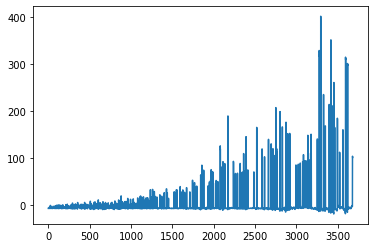

In [14]:
plt.plot(losses)

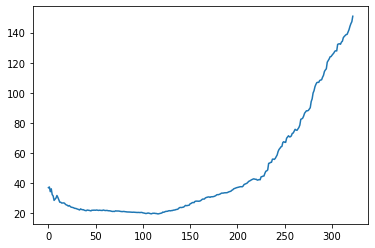

In [15]:
plt.plot(scores_mean)

## Tensorflow 2.0 Implementation

We translated from [eungeunrho/minimalRL](https://github.com/seungeunrho/minimalRL).

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import random

import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

#Hyperparameters
learning_rate = 5e-4
gamma         = 1
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

losses = []
class PPO(Model):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        self.fc1   = layers.Dense(64, activation='relu')#, kernel_initializer='he_uniform')
        self.fc_pi = layers.Dense(2, activation='softmax')#, kernel_initializer='he_uniform')
        self.fc_v  = layers.Dense(1, activation=None)#,kernel_initializer='he_uniform')
        self.optimizer = tf.keras.optimizers.Adam(lr=learning_rate)#, amsgrad=True)
        
    def pi(self, x):
        x = self.fc1(x)
        prob = self.fc_pi(x)
        return prob
    
    def v(self, x):
        x = self.fc1(x)
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s = tf.convert_to_tensor(s_lst,dtype=tf.float32)
        a = tf.convert_to_tensor(a_lst,dtype=tf.int32)
        r = tf.convert_to_tensor(r_lst,dtype=tf.float32)
        s_prime = tf.convert_to_tensor(s_prime_lst,dtype=tf.float32)
        prob_a = tf.convert_to_tensor(prob_a_lst,dtype=tf.float32)
        done_mask = tf.convert_to_tensor(done_lst,dtype=tf.float32)
        
        self.data = []
        return s, a, r, s_prime, prob_a, done_mask
        
    def train_net(self):
        s, a, r, s_prime, prob_a, done_mask  = self.make_batch()
        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = tf.convert_to_tensor(advantage_lst, dtype=tf.float32)
            
            with tf.GradientTape() as tape:
                pi = self.pi(s)
                idx = tf.stack([tf.range(tf.shape(a)[0]),a[:,0]],axis=-1)
                pi_a = tf.gather_nd(pi,idx)[:,None]
                ratio = tf.math.exp(tf.math.log(pi_a) - tf.math.log(prob_a)) 
                surr1 = ratio * advantage
                surr2 = tf.clip_by_value(ratio, 1-eps_clip, 1+eps_clip) * advantage
                actor_loss = tf.math.minimum(surr1,surr2)
                critic_loss_fn = tf.keras.losses.MeanSquaredError()
                critic_loss = critic_loss_fn(td_target, self.v(s))
                loss = -actor_loss + critic_loss
                loss = tf.reduce_mean(loss)
                gradients = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients,self.trainable_weights))
            losses.append(loss.numpy())
            
scores_deque = deque(maxlen=100) 
scores_mean = []
env = gym.make('CartPole-v1')
model = PPO()

for n_epi in range(500):
    s = env.reset()
    done = False
    score = 0
    while not done:
        for t in range(T_horizon):
            prob = model.pi(tf.convert_to_tensor(s,dtype=tf.float32)[None,:])
            m = tfp.distributions.Categorical(prob)
            a = m.sample().numpy()[0]
            s_prime, r, done, info = env.step(a)
            score+=r
            model.put_data((s, a, r/100, s_prime, prob[0,a].numpy(), done))
            s = s_prime

            if done:
                break

        model.train_net()
    scores_deque.append(score)
    scores_mean.append(np.mean(scores_deque))

    if n_epi%100==0 and n_epi!=0:
        print(f'Episode {n_epi}: mean average score at {scores_mean[-1]}')
    if scores_mean[-1] > 150: 
        print(f'Solved at {n_epi} {scores_mean[-1]}')
        break

env.close()

Episode 100: mean average score at 24.87
Episode 200: mean average score at 31.87
Episode 300: mean average score at 71.4
Episode 400: mean average score at 99.36


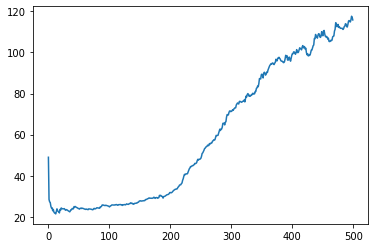

In [5]:
plt.plot(scores_mean)

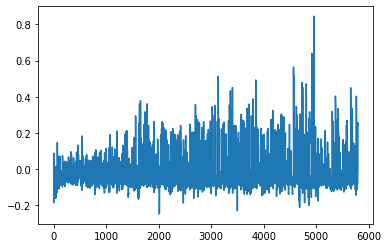

In [6]:
plt.plot(losses)

In [7]:
scores_mean[-1]

115.76